In [1]:
#CELL 1

import ee
import geemap
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import geopandas as gpd
from IPython.display import FileLink, display, HTML
import requests
from PIL import Image
from io import BytesIO

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    try:
        ee.Authenticate()
        ee.Initialize()
    except Exception as auth_e:
        try:
            ee.Initialize(project='ee-imbuckley')
        except Exception as proj_e:
            print("Failed to initialize Earth Engine. Please ensure you have proper credentials.")

In [2]:
#CELL 2

# ======== LOAD LAGOON DATA ========

def load_lagoon_coordinates(file_path="lagoon_coordinates.csv"):
    """Load lagoon coordinates from CSV as fallback"""
    try:
        # Check if file exists in current directory
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            print("Current directory:", os.getcwd())
            print("Available files:", os.listdir("."))
            file_path = input("Enter correct path to coordinates file: ")
        
        # Load the CSV
        lagoon_data = pd.read_csv(file_path)
        print(f"Successfully loaded {len(lagoon_data)} lagoons from {file_path}")
        
        # Show first few lagoons
        print("First few lagoons:")
        for i, row in lagoon_data.head().iterrows():
            print(f"  - {row['lagoon']} ({row['latitude']}, {row['longitude']})")
            
        return lagoon_data
    except Exception as e:
        print(f"Error loading lagoon coordinates: {e}")
        return None

# ======== GEOJSON HANDLING FUNCTIONS ========

def load_geojson(file_path):
    """Load lagoon boundaries from GeoJSON file"""
    try:
        # Check if file exists in current directory
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            print("Current directory:", os.getcwd())
            print("Available files:", os.listdir("."))
            file_path = input("Enter correct path to GeoJSON file: ")
        
        # Load the GeoJSON file
        gdf = gpd.read_file(file_path)
        print(f"Successfully loaded {len(gdf)} features from {file_path}")
        
        # Check coordinate system
        if gdf.crs and gdf.crs != "EPSG:4326":
            print(f"Warning: GeoJSON is not in WGS84 (EPSG:4326). Current CRS: {gdf.crs}")
            print("Reprojecting to WGS84...")
            gdf = gdf.to_crs("EPSG:4326")
        
        # Show the first few features
        print("First few features:")
        for i, row in gdf.head().iterrows():
            # Try to find the name field
            name_field = None
            for col in gdf.columns:
                if col.lower() in ['name', 'lagoon', 'title', 'id']:
                    name_field = col
                    break
            
            if name_field:
                print(f"  - {row[name_field]}")
            else:
                print(f"  - Feature {i+1}")
        
        return gdf
    except Exception as e:
        print(f"Error loading GeoJSON: {e}")
        return None

def geojson_to_ee_features(gdf):
    """Convert GeoDataFrame to Earth Engine FeatureCollection with LagoonName support"""
    # Check for LagoonName column
    name_field = None
    
    # First check for LagoonName specifically
    if 'LagoonName' in gdf.columns:
        name_field = 'LagoonName'
        print(f"Using '{name_field}' column for lagoon names")
    else:
        # Fall back to other name columns
        for col in gdf.columns:
            if col.lower() in ['name', 'lagoon', 'title', 'id', 'lagoonname']:
                name_field = col
                print(f"Using '{name_field}' column for lagoon names")
                break
    
    # If still no name field found, create one
    if name_field is None:
        print("No name column found in GeoJSON. Creating 'lagoon' column with default names.")
        # Create a new column with default names
        gdf['lagoon'] = [f"Lagoon_{i+1}" for i in range(len(gdf))]
        name_field = 'lagoon'
    
    # Check for empty values in the name field and replace with default names
    for i, row in gdf.iterrows():
        if pd.isna(row[name_field]) or row[name_field] == '':
            print(f"Row {i+1} has empty name. Setting to 'Lagoon_{i+1}'")
            gdf.at[i, name_field] = f"Lagoon_{i+1}"
    
    # Show the lagoons with their names
    print("\nLagoons in your GeoJSON:")
    for i, row in gdf.iterrows():
        print(f"{i+1}. {row[name_field]}")
    
    # Create a list of Earth Engine features
    features = []
    lagoon_features_dict = {}
    
    for i, row in gdf.iterrows():
        try:
            # Get the geometry
            geom = row.geometry
            
            # Skip invalid geometries
            if geom is None or not geom.is_valid:
                print(f"Skipping feature {i+1}: Invalid geometry")
                continue
            
            # Get the lagoon name
            lagoon_name = str(row[name_field])
            
            # Convert geometry to GeoJSON format
            geojson = geom.__geo_interface__
            
            # Create Earth Engine geometry
            ee_geom = ee.Geometry(geojson)
            
            # Create Earth Engine feature with the lagoon name as property
            feature = ee.Feature(ee_geom, {'lagoon': lagoon_name})
            features.append(feature)
            
            # Store in dictionary for later use
            lagoon_features_dict[lagoon_name] = feature
            
            print(f"Processed feature: {lagoon_name}")
            
        except Exception as e:
            print(f"Error processing feature {i+1}: {e}")
    
    # Create a feature collection
    if features:
        ee_collection = ee.FeatureCollection(features)
        print(f"Created {len(features)} features in Earth Engine")
        return ee_collection, lagoon_features_dict
    else:
        print("No valid features created")
        return None, None

def create_buffer_features_fallback(lagoon_data, buffer_size=0.05):
    """Create buffer features from coordinates as fallback"""
    features = []
    lagoon_features_dict = {}
    
    for i, row in lagoon_data.iterrows():
        try:
            # Get lagoon name and coordinates
            lagoon_name = row['lagoon']
            lat = float(row['latitude'])
            lon = float(row['longitude'])
            
            # Check if control points exist
            has_control = False
            if 'con_lat' in row and 'con_long' in row:
                if not pd.isna(row['con_lat']) and not pd.isna(row['con_long']):
                    con_lat = float(row['con_lat'])
                    con_lon = float(row['con_long'])
                    has_control = True
            
            # Create geometry based on available points
            if has_control:
                # Create a rectangle that encompasses both points
                min_lat = min(lat, con_lat) - buffer_size/4
                max_lat = max(lat, con_lat) + buffer_size/4
                min_lon = min(lon, con_lon) - buffer_size/4
                max_lon = max(lon, con_lon) + buffer_size/4
                
                # Create a rectangle geometry
                geometry = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
                print(f"Created rectangle for {lagoon_name} using control points")
            else:
                # Create a buffer around the main point (convert degrees to meters approximately)
                # 1 degree is approximately 111,320 meters at the equator
                buffer_meters = buffer_size * 111320
                point = ee.Geometry.Point([lon, lat])
                geometry = point.buffer(buffer_meters)
                print(f"Created buffer for {lagoon_name} with {buffer_size} degree radius")
            
            # Create a feature with the lagoon name as property
            feature = ee.Feature(geometry, {'lagoon': lagoon_name})
            features.append(feature)
            
            # Store in dictionary for later use
            lagoon_features_dict[lagoon_name] = feature
            
        except Exception as e:
            print(f"Error creating feature for {row['lagoon']}: {e}")
    
    # Create a feature collection if we have features
    if features:
        ee_collection = ee.FeatureCollection(features)
        print(f"Created {len(features)} lagoon features from coordinates")
        return ee_collection, lagoon_features_dict
    else:
        print("No valid features created")
        return None, None


In [3]:
#CELL 3

def generate_biweekly_dates(start_year, end_year):
    """Generate biweekly date ranges for the analysis"""
    date_ranges = []
    for year in range(start_year, end_year + 1):
        # Start from January 1st of each year
        current_date = datetime(year, 1, 1)
        while current_date.year == year:
            start_date = current_date
            end_date = current_date + timedelta(days=13)  # 14 days (biweekly)
            date_ranges.append((start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')))
            current_date = end_date + timedelta(days=1)  # Move to the next period
    return date_ranges


def calculate_indices(image):
    """Calculate both NDSI and NDWI for better ice/water differentiation"""
    # NDSI uses green (B3) and SWIR (B11)
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    
    # NDWI uses green (B3) and NIR (B8)
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    
    # Add both indices to the image
    return image.addBands(ndsi).addBands(ndwi)

def detect_ice(image):
    """Detect ice using a combination of NDSI and NDWI"""
    # High NDSI and low NDWI indicates ice
    # Ice typically has NDSI > 0.4 and NDWI < 0
    ice_mask = image.select('NDSI').gt(0.4).And(image.select('NDWI').lt(0))
    
    # Return the mask
    return ice_mask.rename('ice')

def mask_clouds(image):
    """Mask clouds using the QA60 band"""
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

def analyze_lagoon_ice(lagoon_name, ee_features, lagoon_features_dict, 
                      lagoon_coordinates, start_year=2019, end_year=2024):
    """Analyze ice coverage for a specific lagoon with improved ice detection"""
    
    # Get the lagoon feature
    lagoon_feature = None
    
    if lagoon_name in lagoon_features_dict:
        lagoon_feature = lagoon_features_dict[lagoon_name]
    else:
        fc_filtered = ee_features.filter(ee.Filter.eq('lagoon', lagoon_name))
        count = fc_filtered.size().getInfo()
        if count > 0:
            lagoon_feature = fc_filtered.first()
        else:
            print(f"Lagoon '{lagoon_name}' not found in the feature collection")
            return None
    
    # Get the lagoon geometry
    roi = lagoon_feature.geometry()
    
    # Get coordinates for the lagoon from the coordinates DataFrame
    if lagoon_coordinates is not None and 'latitude' in lagoon_coordinates.columns and 'longitude' in lagoon_coordinates.columns:
        lagoon_data = lagoon_coordinates[lagoon_coordinates['lagoon'] == lagoon_name]
        if not lagoon_data.empty:
            latitude = lagoon_data['latitude'].iloc[0]
            longitude = lagoon_data['longitude'].iloc[0]
        else:
            # Fallback to centroid if not found in coordinates
            centroid = roi.centroid().coordinates().getInfo()
            longitude, latitude = centroid
    else:
        # Fallback to centroid
        centroid = roi.centroid().coordinates().getInfo()
        longitude, latitude = centroid
    
    # Generate biweekly date ranges
    date_ranges = generate_biweekly_dates(start_year, end_year)
    
    # Create a list to store results
    results_list = []
    
    for start_date, end_date in date_ranges:
        try:
            # Load Sentinel-2 images for this period
            sentinel_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                                 .filterBounds(roi)
                                 .filterDate(start_date, end_date)
                                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                                 .map(mask_clouds)
                                 .map(calculate_indices))  # Using the improved index calculation
            
            # If we have images in this period
            image_count = sentinel_collection.size().getInfo()
            
            if image_count > 0:
                # Get median composite
                median_image = sentinel_collection.median()
                
                # Apply improved ice detection
                ice_mask = detect_ice(median_image)
                
                # Calculate ice statistics
                stats = ice_mask.updateMask(median_image.select('B2').mask()).reduceRegion(
                    reducer=ee.Reducer.count(),
                    geometry=roi,
                    scale=10,
                    maxPixels=1e9
                )
                total_pixels = ee.Number(stats.get('ice'))
                
                ice_stats = ice_mask.updateMask(ice_mask).reduceRegion(
                    reducer=ee.Reducer.count(),
                    geometry=roi,
                    scale=10,
                    maxPixels=1e9
                )
                ice_pixels = ee.Number(ice_stats.get('ice'))
                
                # Calculate percentage with validation
                ice_percentage = ee.Number(ee.Algorithms.If(
                    total_pixels.gt(0),
                    ice_pixels.divide(total_pixels).multiply(100),
                    0
                )).getInfo()
                
                # Add seasonal context for validation
                month = datetime.strptime(start_date, '%Y-%m-%d').month
                season = "winter" if month in [12, 1, 2, 3, 4] else "summer"
                
                # Store the result
                results_list.append({
                    'lagoon': lagoon_name,
                    'date': start_date,
                    'latitude': latitude,
                    'longitude': longitude,
                    'ice_coverage_pct': ice_percentage,
                    'season': season,
                    'image_count': image_count
                })
                
                print(f"Processed {start_date} to {end_date}: {ice_percentage:.2f}% ice coverage ({season})")
            else:
                print(f"No suitable images for {start_date} to {end_date}")
                
        except Exception as e:
            print(f"Error processing {start_date} to {end_date}: {e}")
    
    # Convert results to DataFrame
    if results_list:
        results_df = pd.DataFrame(results_list)
        
        # Add flags for suspicious values (e.g., high ice % in summer)
        results_df['suspicious'] = False
        
        # Flag summer readings with >80% ice coverage
        summer_ice = (results_df['season'] == 'summer') & (results_df['ice_coverage_pct'] > 80)
        results_df.loc[summer_ice, 'suspicious'] = True
        
        # Flag winter readings with <20% ice coverage (unless it's early winter or late spring)
        early_winter_months = [12]
        late_spring_months = [4]
        
        results_df['month'] = pd.to_datetime(results_df['date']).dt.month
        winter_no_ice = ((results_df['season'] == 'winter') & 
                         (results_df['ice_coverage_pct'] < 20) & 
                         (~results_df['month'].isin(early_winter_months + late_spring_months)))
        results_df.loc[winter_no_ice, 'suspicious'] = True
        
        # Print warnings for suspicious values
        suspicious_count = results_df['suspicious'].sum()
        if suspicious_count > 0:
            print(f"\nWARNING: {suspicious_count} readings flagged as potentially inaccurate")
            print("These are marked in the results with a 'suspicious' flag")
        
        return results_df
    else:
        return pd.DataFrame()

def analyze_multiple_lagoons(lagoon_names, ee_features, lagoon_features_dict, 
                           lagoon_coordinates, start_year=2019, end_year=2024):
    """Analyze multiple lagoons with improved ice detection"""
    all_results = pd.DataFrame()
    
    for lagoon_name in lagoon_names:
        print(f"\nAnalyzing {lagoon_name}...")
        lagoon_results = analyze_lagoon_ice(lagoon_name, ee_features, lagoon_features_dict, 
                                          lagoon_coordinates, start_year, end_year)
        
        if lagoon_results is not None and not lagoon_results.empty:
            all_results = pd.concat([all_results, lagoon_results], ignore_index=True)
            
            # Save intermediate results after each lagoon to avoid data loss
            temp_filename = f"temp_ice_coverage_results_{start_year}_{end_year}.csv"
            all_results.to_csv(temp_filename, index=False)
    
    return all_results

In [4]:
#CELL 4


# ========================================================================
# CELL 4: VISUALIZATION AND OUTPUT FUNCTIONS
# ========================================================================
# This cell contains functions for visualizing results and saving to CSV files

def add_visualization_features():
    """Add additional visualization functions to geemap"""
    try:
        # Function to add a title to the map
        def add_title(self, title, fontsize=16, position='position: absolute; top: 10px; left: 50%; transform: translateX(-50%);', 
                    style=None):
            """Adds a title to the map."""
            if style is None:
                style = f'font-size: {fontsize}px; font-weight: bold; background-color: rgba(255, 255, 255, 0.8); padding: 10px; border-radius: 5px; {position}'
            else:
                style = f'{style}; {position}'
            
            title_html = f'''
                <div style="{style}">
                    {title}
                </div>
            '''
            self.add_html(title_html)
        
        # Function to add a legend to the map
        def add_legend(self, title="Legend", legend_dict=None, position='bottomright'):
            """Adds a legend to the map."""
            if legend_dict is None:
                legend_dict = {}
            
            legend_html = f'''
                <div class="legend" style="background-color: rgba(255, 255, 255, 0.8); padding: 10px; border-radius: 5px;">
                    <h4>{title}</h4>
                    <div style="margin-top: 5px;">
            '''
            
            for label, color in legend_dict.items():
                legend_html += f'''
                    <div>
                        <span style="display: inline-block; width: 12px; height: 12px; background-color: {color}; margin-right: 5px;"></span>
                        <span>{label}</span>
                    </div>
                '''
            
            legend_html += '''
                    </div>
                </div>
            '''
            
            self.add_html(legend_html, position=position)
        
        # Add these functions to the geemap.Map class
        geemap.Map.add_title = add_title
        geemap.Map.add_legend = add_legend
        
        print("Visualization features added successfully")
    except Exception as e:
        print(f"Error adding visualization features: {e}")

def show_ndsi_image(lagoon_name, date_str, ee_features, lagoon_features_dict):
    """Display NDSI as static images using matplotlib"""
    
    # Get the lagoon feature
    if lagoon_name not in lagoon_features_dict:
        print(f"Lagoon '{lagoon_name}' not found")
        return None
    
    lagoon_feature = lagoon_features_dict[lagoon_name]
    roi = lagoon_feature.geometry()
    roi_buffer = roi.buffer(1000)  # Add buffer for context
    
    # Parse date
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        start_date = (date - timedelta(days=3)).strftime('%Y-%m-%d')
        end_date = (date + timedelta(days=3)).strftime('%Y-%m-%d')
    except ValueError:
        print("Invalid date format")
        return None
    
    print(f"Getting imagery for {lagoon_name} from {start_date} to {end_date}")
    
    # Get Sentinel-2 imagery
    sentinel_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                          .filterBounds(roi)
                          .filterDate(start_date, end_date)
                          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                          .map(mask_clouds)
                          .map(calculate_indices))
    
    # Check for images
    image_count = sentinel_collection.size().getInfo()
    if image_count == 0:
        print(f"No images found for {lagoon_name} on {date_str}")
        return None
    
    print(f"Found {image_count} images. Creating median composite.")
    
    # Get median composite
    median_image = sentinel_collection.median()
    
    # Calculate ice mask using improved method
    ice_mask = detect_ice(median_image)
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: True Color Image
    try:
        rgb_url = median_image.clip(roi_buffer).getThumbUrl({
            'bands': ['B4', 'B3', 'B2'],
            'min': 0,
            'max': 3000,
            'dimensions': 512,
            'region': roi_buffer.getInfo()
        })
        
        response = requests.get(rgb_url)
        img = Image.open(BytesIO(response.content))
        
        axes[0].imshow(img)
        axes[0].set_title(f"{lagoon_name} - True Color", fontsize=14)
        axes[0].axis('off')
    except Exception as e:
        print(f"Error displaying true color image: {e}")
        axes[0].text(0.5, 0.5, 'Error loading true color', ha='center', va='center')
    
    # Plot 2: NDSI and NDWI visualization
    try:
        # Create a visualization that shows both NDSI and NDWI
        # Bright areas are high NDSI (potential ice)
        ndsi_url = median_image.select('NDSI').clip(roi_buffer).getThumbUrl({
            'min': -0.5,
            'max': 0.8,
            'dimensions': 512,
            'palette': ['blue', 'cyan', 'white', 'yellow', 'red'],
            'region': roi_buffer.getInfo()
        })
        
        response = requests.get(ndsi_url)
        img = Image.open(BytesIO(response.content))
        
        axes[1].imshow(img)
        axes[1].set_title(f"{lagoon_name} - NDSI Values", fontsize=14)
        axes[1].axis('off')
        
        # Add colorbar for NDSI
        from matplotlib.colors import LinearSegmentedColormap
        colors = ['blue', 'cyan', 'white', 'yellow', 'red']
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('ndsi', colors, N=n_bins)
        
        # Create a ScalarMappable
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.5, vmax=0.8))
        sm.set_array([])
        plt.colorbar(sm, ax=axes[1], fraction=0.046, pad=0.04, label='NDSI Values')
        
    except Exception as e:
        print(f"Error displaying NDSI image: {e}")
        axes[1].text(0.5, 0.5, 'Error loading NDSI', ha='center', va='center')
    
    # Plot 3: Ice Mask (using improved detection)
    try:
        ice_url = ice_mask.clip(roi_buffer).getThumbUrl({
            'min': 0,
            'max': 1,
            'dimensions': 512,
            'palette': ['000000', 'red'],
            'region': roi_buffer.getInfo()
        })
        
        response = requests.get(ice_url)
        img = Image.open(BytesIO(response.content))
        
        axes[2].imshow(img)
        axes[2].set_title(f"{lagoon_name} - Ice Cover (Improved Detection)", fontsize=14)
        axes[2].axis('off')
    except Exception as e:
        print(f"Error displaying ice mask: {e}")
        axes[2].text(0.5, 0.5, 'Error loading ice mask', ha='center', va='center')
    
    # Calculate ice coverage percentage
    try:
        # Calculate ice coverage using improved method
        stats = ice_mask.updateMask(median_image.select('B2').mask()).reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=roi,
            scale=10,
            maxPixels=1e9
        )
        total_pixels = ee.Number(stats.get('ice'))
        
        ice_stats = ice_mask.updateMask(ice_mask).reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=roi,
            scale=10,
            maxPixels=1e9
        )
        ice_pixels = ee.Number(ice_stats.get('ice'))
        
        # Calculate percentage
        ice_percentage = ee.Number(ee.Algorithms.If(
            total_pixels.gt(0),
            ice_pixels.divide(total_pixels).multiply(100),
            0
        )).getInfo()
        
        # Add ice coverage text to plot
        month = date.month
        season = "winter" if month in [12, 1, 2, 3, 4] else "summer"
        suspicious = False
        
        # Check if the reading is suspicious
        if season == "summer" and ice_percentage > 80:
            suspicious = True
        elif season == "winter" and ice_percentage < 20 and month not in [12, 4]:
            suspicious = True
        
        title = f"{lagoon_name} - {date_str} - Ice Coverage: {ice_percentage:.2f}% ({season})"
        if suspicious:
            title += " ⚠️ Potentially inaccurate"
        
        fig.suptitle(title, fontsize=16, fontweight='bold')
    except Exception as e:
        print(f"Error calculating ice coverage: {e}")
        fig.suptitle(f"{lagoon_name} - {date_str}", fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'ice_percentage': ice_percentage if 'ice_percentage' in locals() else None,
        'image_count': image_count
    }

def save_clean_results(results_df, filename=None):
    """Save results to CSV with only the desired columns and suspicious flags"""
    
    if results_df is None or results_df.empty:
        print("No results to save.")
        return
    
    # Create a clean DataFrame for output
    columns_to_export = ['lagoon', 'date', 'latitude', 'longitude', 'ice_coverage_pct', 'season']
    if 'suspicious' in results_df.columns:
        columns_to_export.append('suspicious')
    
    # Select only columns that exist in the DataFrame
    clean_df = results_df[[col for col in columns_to_export if col in results_df.columns]].copy()
    
    # Sort by lagoon and date
    clean_df = clean_df.sort_values(['lagoon', 'date'])
    
    # Format ice_coverage_pct to show 2 decimal places
    if 'ice_coverage_pct' in clean_df.columns:
        clean_df['ice_coverage_pct'] = clean_df['ice_coverage_pct'].round(2)
    
    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"lagoon_ice_analysis_{timestamp}.csv"
    
    # Save to CSV
    try:
        clean_df.to_csv(filename, index=False)
        print(f"\nResults saved to: {filename}")
        
        # Create download link
        if os.path.exists(filename):
            display(FileLink(filename))
            print(f"Click the link above to download the CSV file.")
            
            # Display preview of the data
            print("\nPreview of results:")
            
            # If suspicious flag exists, create a styled DataFrame with highlights
            if 'suspicious' in clean_df.columns:
                def highlight_suspicious(s):
                    return ['background-color: #ffcccc' if v else '' for v in s]
                
                display(clean_df.head(10).style.apply(highlight_suspicious, subset=['suspicious']))
                
                # Display summary statistics
                suspicious_count = clean_df['suspicious'].sum()
                print(f"\nTotal records: {len(clean_df)}")
                print(f"Suspicious records: {suspicious_count} ({suspicious_count/len(clean_df)*100:.1f}%)")
            else:
                # Just display the dataframe normally
                display(clean_df.head(10))
                print(f"\nTotal records: {len(clean_df)}")
        else:
            print(f"File {filename} was not created successfully.")
            
    except Exception as e:
        print(f"Error saving CSV file: {e}")

Visualization features added successfully
===== Lagoon Ice Coverage Analysis with Improved Ice Detection =====
1. Run new analysis
2. Visualize existing results
3. Exit



Enter your choice (1-3):  1



Select the source of lagoon boundaries:
1. Load from GeoJSON file
2. Use coordinates from lagoon_coordinates.csv with buffer zones



Enter your choice (1 or 2):  1


Loaded lagoon coordinates for location information



Enter path to GeoJSON file:  LagoonsPolygon.geojson


Successfully loaded 25 features from LagoonsPolygon.geojson
First few features:
  - Krusenstern
  - Kotlik
  - Aukulak
  - Kivalina
  - Ikpek
Using 'lagoon' column for lagoon names

Lagoons in your GeoJSON:
1. Krusenstern
2. Kotlik
3. Aukulak
4. Kivalina
5. Ikpek
6. Kupik
7. Aiautak
8. Kemegrak
9. Akoviknak
10. Atosik
11. Mapsorak
12. Pusigrak
13. Singoalik
14. Seppings
15. Tasikpak
16. Pusaluk
17. Tugak
18. Kavrorak
19. Asikpak
20. Imukruk
21. Ipiavik
22. Tsaitsat Angayukangnk
23. Imik
24. Tasaychek
25. Atilagauraq
Processed feature: Krusenstern
Skipping feature 2: Invalid geometry
Processed feature: Aukulak
Processed feature: Kivalina
Processed feature: Ikpek
Processed feature: Kupik
Processed feature: Aiautak
Processed feature: Kemegrak
Processed feature: Akoviknak
Processed feature: Atosik
Processed feature: Mapsorak
Skipping feature 12: Invalid geometry
Processed feature: Singoalik
Processed feature: Seppings
Processed feature: Tasikpak
Processed feature: Pusaluk
Processed feature

 1



Analyzing these lagoons: Krusenstern



Enter start year (2019-2024, default 2019):  2019
Enter end year (must be >= 2019 and <= 2024, default 2019):  2019



Analyzing Krusenstern...
No suitable images for 2019-01-01 to 2019-01-14
No suitable images for 2019-01-15 to 2019-01-28
No suitable images for 2019-01-29 to 2019-02-11
Processed 2019-02-12 to 2019-02-25: 99.94% ice coverage (winter)
No suitable images for 2019-02-26 to 2019-03-11
Processed 2019-03-12 to 2019-03-25: 74.28% ice coverage (winter)
Processed 2019-03-26 to 2019-04-08: 0.18% ice coverage (winter)
Processed 2019-04-09 to 2019-04-22: 0.60% ice coverage (winter)
Processed 2019-04-23 to 2019-05-06: 0.09% ice coverage (winter)
Processed 2019-05-07 to 2019-05-20: 0.53% ice coverage (summer)
No suitable images for 2019-05-21 to 2019-06-03
Processed 2019-06-04 to 2019-06-17: 0.01% ice coverage (summer)
Processed 2019-06-18 to 2019-07-01: 0.00% ice coverage (summer)
Processed 2019-07-02 to 2019-07-15: 0.00% ice coverage (summer)
Processed 2019-07-16 to 2019-07-29: 0.01% ice coverage (summer)
Processed 2019-07-30 to 2019-08-12: 0.01% ice coverage (summer)
Processed 2019-08-13 to 2019

/home/jovyan/WCS/lagoon_ice_analysis_20250425_185925.csv

Click the link above to download the CSV file.

Preview of results:


,lagoon,date,latitude,longitude,ice_coverage_pct,season,suspicious
0,Krusenstern,2019-02-12,67.150000,-163.640000,99.940000,winter,False
1,Krusenstern,2019-03-12,67.150000,-163.640000,74.280000,winter,False
2,Krusenstern,2019-03-26,67.150000,-163.640000,0.180000,winter,True
3,Krusenstern,2019-04-09,67.150000,-163.640000,0.600000,winter,False
4,Krusenstern,2019-04-23,67.150000,-163.640000,0.090000,winter,False
5,Krusenstern,2019-05-07,67.150000,-163.640000,0.530000,summer,False
6,Krusenstern,2019-06-04,67.150000,-163.640000,0.010000,summer,False
7,Krusenstern,2019-06-18,67.150000,-163.640000,0.000000,summer,False
8,Krusenstern,2019-07-02,67.150000,-163.640000,0.000000,summer,False
9,Krusenstern,2019-07-16,67.150000,-163.640000,0.010000,summer,False



Total records: 15
Suspicious records: 1 (6.7%)



Would you like to visualize any specific lagoon/date combinations? (y/n):  y

Enter lagoon name to visualize (or 'exit' to quit):  Krusenstern
Enter date to visualize (YYYY-MM-DD):  2019-06-04


Getting imagery for Krusenstern from 2019-06-01 to 2019-06-07
Found 1 images. Creating median composite.


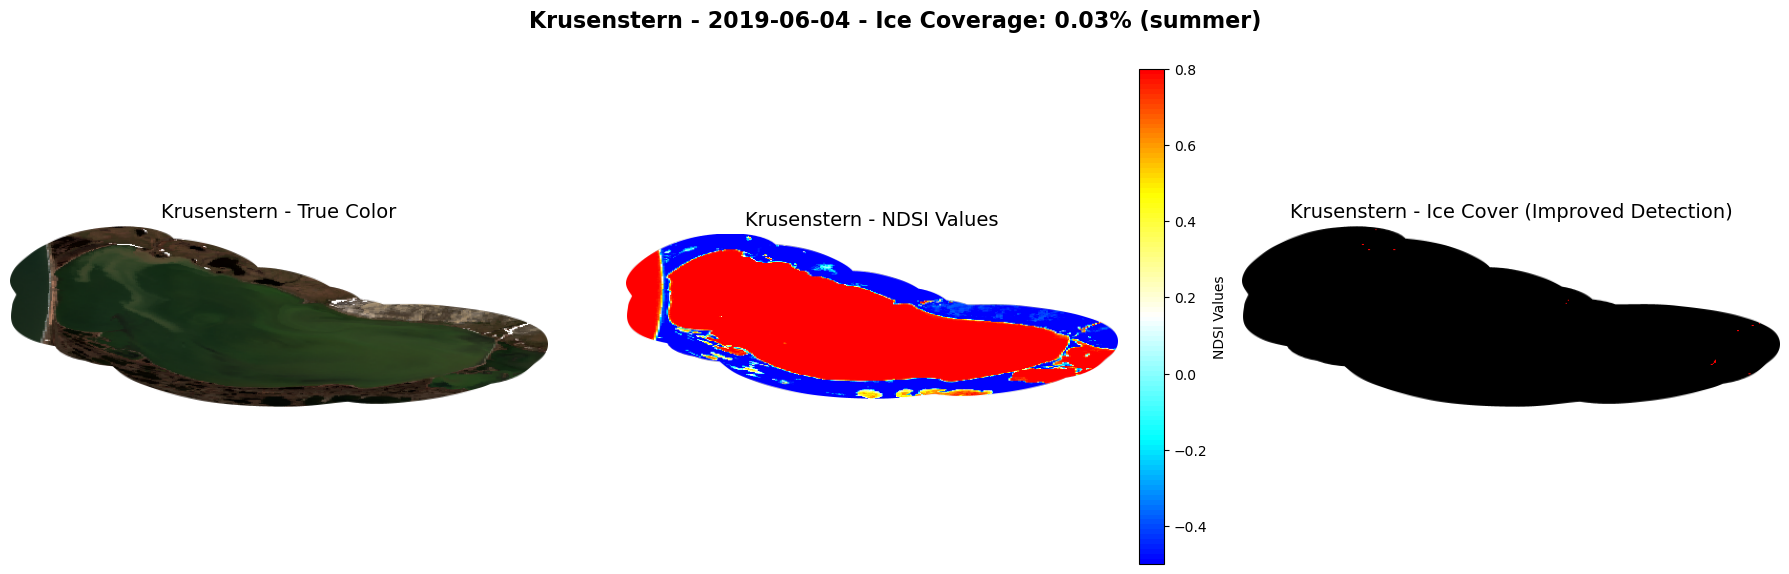


Enter lagoon name to visualize (or 'exit' to quit):  Krusenstern
Enter date to visualize (YYYY-MM-DD):  2019-03-12


Getting imagery for Krusenstern from 2019-03-09 to 2019-03-15
No images found for Krusenstern on 2019-03-12



Enter lagoon name to visualize (or 'exit' to quit):  Krusenstern
Enter date to visualize (YYYY-MM-DD):  2019-03-26


Getting imagery for Krusenstern from 2019-03-23 to 2019-03-29
Found 1 images. Creating median composite.


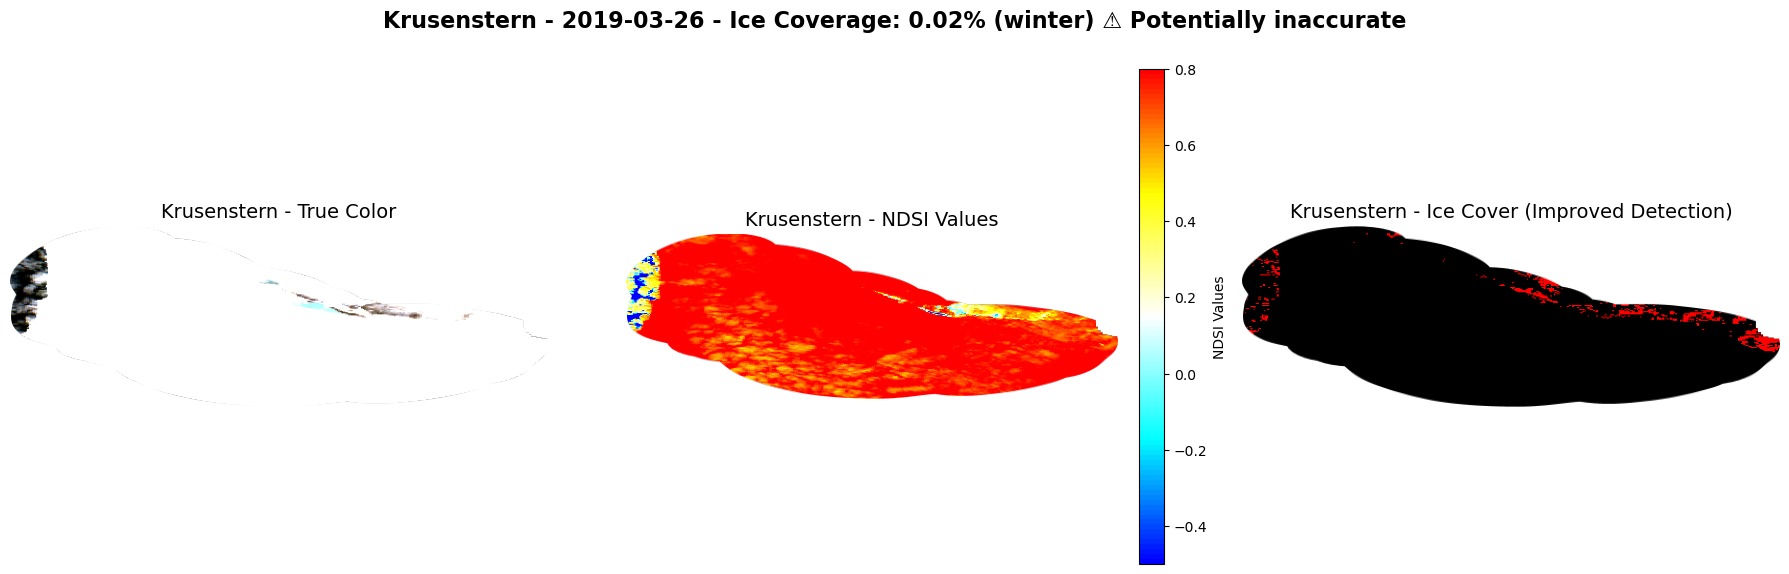

In [ ]:
#CELL 5

def run_lagoon_analysis():
    """Run the ice coverage analysis with improved ice detection"""
    
    # Ask user for GeoJSON file
    print("\nSelect the source of lagoon boundaries:")
    print("1. Load from GeoJSON file")
    print("2. Use coordinates from lagoon_coordinates.csv with buffer zones")
    
    boundary_choice = input("\nEnter your choice (1 or 2): ")
    
    # Also load the coordinates CSV for latitude/longitude info
    lagoon_coordinates = None
    try:
        lagoon_coordinates = pd.read_csv("lagoon_coordinates.csv")
        print("Loaded lagoon coordinates for location information")
    except Exception as e:
        print(f"Could not load lagoon coordinates file: {e}")
        # Create empty DataFrame to avoid errors
        lagoon_coordinates = pd.DataFrame()
    
    if boundary_choice == '1':
        # Load from GeoJSON
        geojson_path = input("\nEnter path to GeoJSON file: ")
        gdf = load_geojson(geojson_path)
        
        if gdf is None:
            print("Failed to load GeoJSON. Falling back to coordinates with buffers.")
            if lagoon_coordinates.empty:
                print("No coordinate data available. Exiting.")
                return
                
            # Ask for buffer size
            buffer_input = input("\nEnter buffer size in degrees for each lagoon (default: 0.05): ")
            buffer_size = float(buffer_input) if buffer_input.strip() else 0.05
            
            # Create features using buffer approach
            ee_features, lagoon_features_dict = create_buffer_features_fallback(lagoon_coordinates, buffer_size)
        else:
            # Convert GeoJSON to Earth Engine features
            ee_features, lagoon_features_dict = geojson_to_ee_features(gdf)
    else:
        # Use coordinates with buffers
        if lagoon_coordinates.empty:
            print("No coordinate data available. Exiting.")
            return
            
        # Ask for buffer size
        buffer_input = input("\nEnter buffer size in degrees for each lagoon (default: 0.05): ")
        buffer_size = float(buffer_input) if buffer_input.strip() else 0.05
        
        # Create features using buffer approach
        ee_features, lagoon_features_dict = create_buffer_features_fallback(lagoon_coordinates, buffer_size)
    
    if ee_features is None:
        print("Failed to create lagoon features. Exiting.")
        return
    
    # Get list of lagoon names
    lagoon_names = list(lagoon_features_dict.keys())
    
    # Let user select which lagoons to analyze
    print("\nAvailable lagoons:")
    for i, name in enumerate(lagoon_names):
        print(f"{i+1}. {name}")
    
    print("\nWhich lagoons would you like to analyze?")
    print("Enter the numbers separated by commas, or 'all' for all lagoons:")
    selection = input()
    
    if selection.lower() != 'all':
        try:
            indices = [int(idx.strip()) - 1 for idx in selection.split(',')]
            selected_lagoons = [lagoon_names[i] for i in indices if 0 <= i < len(lagoon_names)]
            
            if not selected_lagoons:
                print("Invalid selection. Analyzing all lagoons.")
                selected_lagoons = lagoon_names
        except (ValueError, IndexError):
            print("Invalid selection. Analyzing all lagoons.")
            selected_lagoons = lagoon_names
    else:
        selected_lagoons = lagoon_names
    
    print(f"\nAnalyzing these lagoons: {', '.join(selected_lagoons)}")
    
    # Let user select year range
    start_year_input = input("\nEnter start year (2019-2024, default 2019): ").strip()
    try:
        start_year = int(start_year_input) if start_year_input else 2019
        if start_year < 2019 or start_year > 2024:
            start_year = 2019
            print(f"Invalid year. Using default start year: {start_year}")
    except ValueError:
        start_year = 2019
        print(f"Using default start year: {start_year}")
    
    end_year_input = input(f"Enter end year (must be >= {start_year} and <= 2024, default {start_year}): ").strip()
    try:
        end_year = int(end_year_input) if end_year_input else start_year
        if end_year < start_year or end_year > 2024:
            end_year = min(2024, start_year + 1)
            print(f"Invalid year. Using default end year: {end_year}")
    except ValueError:
        end_year = min(2024, start_year + 1)
        print(f"Using default end year: {end_year}")
    
    # Run the analysis
    results = analyze_multiple_lagoons(selected_lagoons, ee_features, lagoon_features_dict, 
                                     lagoon_coordinates, start_year, end_year)
    
    # Save clean results if we have any
    if not results.empty:
        save_clean_results(results)
        
        # Ask if user wants to visualize specific date/lagoon combinations
        visualize_option = input("\nWould you like to visualize any specific lagoon/date combinations? (y/n): ")
        if visualize_option.lower() == 'y':
            while True:
                lagoon_name = input("\nEnter lagoon name to visualize (or 'exit' to quit): ")
                if lagoon_name.lower() == 'exit':
                    break
                
                date_str = input("Enter date to visualize (YYYY-MM-DD): ")
                show_ndsi_image(lagoon_name, date_str, ee_features, lagoon_features_dict)
    else:
        print("No valid results to save.")
    
    return results, ee_features, lagoon_features_dict

def visualize_existing_results():
    """Load and visualize existing results"""
    # Load results
    results_file = input("Enter path to results CSV file: ")
    
    try:
        results_df = pd.read_csv(results_file)
        print(f"Loaded {len(results_df)} rows from {results_file}")
        
        # Load GeoJSON for boundaries
        geojson_path = input("\nEnter path to GeoJSON file for visualization: ")
        gdf = load_geojson(geojson_path)
        
        if gdf is not None:
            # Convert GeoJSON to Earth Engine features
            ee_features, lagoon_features_dict = geojson_to_ee_features(gdf)
            
            if ee_features is not None:
                # Let user visualize specific lagoons on specific dates
                while True:
                    lagoon_name = input("\nEnter lagoon name to visualize (or 'exit' to quit): ")
                    if lagoon_name.lower() == 'exit':
                        break
                    
                    date_str = input("Enter date to visualize (YYYY-MM-DD): ")
                    show_ndsi_image(lagoon_name, date_str, ee_features, lagoon_features_dict)
        else:
            print("Could not load GeoJSON for visualization.")
    except Exception as e:
        print(f"Error loading results: {e}")

# Run this in the fifth cell to execute the program
if __name__ == "__main__":
    # Add visualization features to geemap
    add_visualization_features()
    
    print("===== Lagoon Ice Coverage Analysis with Improved Ice Detection =====")
    print("1. Run new analysis")
    print("2. Visualize existing results")
    print("3. Exit")
    
    choice = input("\nEnter your choice (1-3): ")
    
    if choice == '1':
        results, ee_features, lagoon_features_dict = run_lagoon_analysis()
    elif choice == '2':
        visualize_existing_results()
    elif choice == '3':
        print("Exiting.")
    else:
        print("Invalid choice. Exiting.")